In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats
# import xgboost as xgb

import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

2024-07-19 14:28:18.950478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 14:28:19.035720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 14:28:19.055903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 14:28:19.294773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 14:28:21.219956: W tensorflow/compiler/tf2

In [2]:
file_path = "../raw_data/Dataset.csv"
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [46]:
#features to drop in the dataset

columns_drop = ['EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2']

columns_for_baseline = ['Hour', 'HR','O2Sat', 'Temp','SBP', 'MAP', 'DBP', 'Resp','Age','Gender','Patient_ID','SepsisLabel']

In [50]:
df1 = df[columns_for_baseline]
df1.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,Patient_ID,SepsisLabel
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,17072,0
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,68.54,0,17072,0
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,68.54,0,17072,0
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,68.54,0,17072,0
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,68.54,0,17072,0


## Reducing the number of Patients 

In [51]:
# Filter patient IDs where at some point sepsis label is 1
sepsis_patients_ids = list(set(df1.loc[df1['SepsisLabel'] == 1, 'Patient_ID'].tolist()))
len(sepsis_patients_ids)

Patient_ID
3658      336
114471    336
101922    336
117406    336
4905      336
         ... 
110085      8
16854       8
118844      8
16161       8
109559      8
Name: count, Length: 40336, dtype: int64

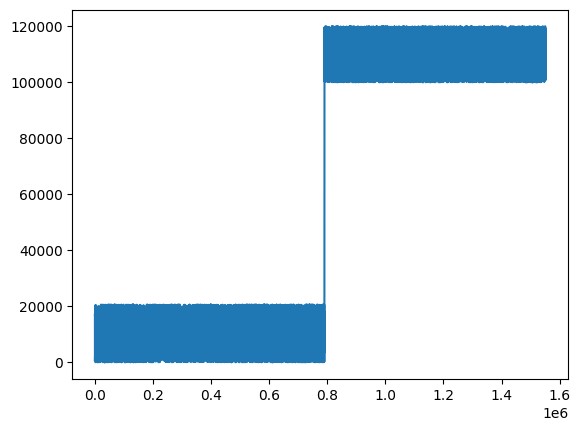

In [53]:
# Get unique Patient_IDs from df_encoded
all_patient_ids = set(df1['Patient_ID'])
# Find Patient_IDs not in sepsis_patients_ids
no_sepsis_patients_ids = list(all_patient_ids - set(sepsis_patients_ids))
len(no_sepsis_patients_ids)

In [54]:
non_sepsis_selected_patients_ids = random.sample(no_sepsis_patients_ids, 4000)

EtCO2          0.962868
Temp           0.661627
DBP            0.313459
Resp           0.153546
SBP            0.145770
O2Sat          0.130611
MAP            0.124513
HR             0.098826
Hour           0.000000
Age            0.000000
Gender         0.000000
Patient_ID     0.000000
SepsisLabel    0.000000
dtype: float64

In [55]:
non_sepsis_selected_df = df1.loc[df1['Patient_ID'].isin(non_sepsis_selected_patients_ids)]
sepsis_selected_df = df1.loc[df1['Patient_ID'].isin(sepsis_patients_ids)]

['Hour',
 'HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'Age',
 'Gender',
 'Patient_ID',
 'SepsisLabel']

In [57]:
final_df = pd.concat([non_sepsis_selected_df,sepsis_selected_df])
final_df.head()

/tmp/ipykernel_28791/3397734120.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df1.groupby('Patient_ID', group_keys=False).apply(


In [70]:
patient_ids = final_df['Patient_ID'].unique()
np.random.shuffle(patient_ids)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Hour         1552210 non-null  int64  
 1   HR           1552068 non-null  float64
 2   O2Sat        1551836 non-null  float64
 3   Temp         1544780 non-null  float64
 4   SBP          1541234 non-null  float64
 5   MAP          1549512 non-null  float64
 6   DBP          1292960 non-null  float64
 7   Resp         1550211 non-null  float64
 8   EtCO2        156170 non-null   float64
 9   Age          1552210 non-null  float64
 10  Gender       1552210 non-null  int64  
 11  Patient_ID   1552210 non-null  int64  
 12  SepsisLabel  1552210 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 154.0 MB


In [71]:
final_df.Patient_ID = final_df.Patient_ID.astype("category")
final_df.Patient_ID = final_df.Patient_ID.cat.set_categories(patient_ids)
final_df_shuffled = final_df.sort_values(["Patient_ID", "Hour"]).set_index('Patient_ID')  ## 'sort' changed to 'patient_ids'

1396040

In [35]:
(final_df.isnull().sum()/len(final_df)).sort_values(ascending=False)

EtCO2          0.962868
Temp           0.661627
DBP            0.313459
Resp           0.153546
SBP            0.145770
O2Sat          0.130611
MAP            0.124513
HR             0.098826
Hour           0.000000
Age            0.000000
Gender         0.000000
Patient_ID     0.000000
SepsisLabel    0.000000
dtype: float64

In [36]:
final_df.info()

In [ ]:
final_df.groupby("Patient_ID", group_keys = False).sum()

In [ ]:
final_df.Patient_ID = final_df.Patient_ID.astype("int")

df_filled = final_df.groupby('Patient_ID', group_keys=False).apply(
    lambda group: group.interpolate().bfill().ffill()
).reset_index(drop=False)

In [ ]:
(cleaned_df.isnull().sum()/len(cleaned_df)).sort_values(ascending=False)

## Scaling the Data

In [37]:
# List of columns to plot
columns_to_scale = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler to the O2Sat column
cleaned_df['O2Sat'] = min_max_scaler.fit_transform(cleaned_df[['O2Sat']])

# Apply StandardScaler to the rest of the columns
columns_to_standardize = [col for col in columns_to_scale if col != 'O2Sat']
cleaned_df[columns_to_standardize] = standard_scaler.fit_transform(cleaned_df[columns_to_standardize])

In [38]:
# Prepare data for LSTM
features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender', "Patient_ID"]
X = cleaned_df[features]
y = cleaned_df['SepsisLabel']

2932

In [39]:
y.value_counts()

37404

In [40]:
def create_sequences(X, y, time_steps=6):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:(i + time_steps)].values)
        y_seq.append(y.iloc[i + time_steps])
    return X_seq, y_seq

In [41]:
X_sequences = []
y_sequences = []

for patient in cleaned_df.sort_values(["Patient_ID", "Hour"]).groupby("Patient_ID"):

    features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender']
    X = patient[1][features]
    y = patient[1]['SepsisLabel']
    X_s, y_s = create_sequences(X,y)

    X_sequences = X_sequences + X_s
    y_sequences = y_sequences + y_s

In [42]:
X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,Patient_ID,SepsisLabel
0,0,-1.118162,1.0,-1.54932,0.225804,-0.657904,0.345603,-0.422295,NaN,68.54,0,17072,0
1,1,-1.118162,1.0,-1.54932,0.225804,-0.657904,0.345603,-0.422295,NaN,68.54,0,17072,0
2,2,-0.368768,1.0,-1.54932,0.225804,-2.465439,0.345603,-0.373317,NaN,68.54,0,17072,0
3,3,-0.656996,1.0,-1.54932,0.225804,-1.500399,0.345603,-0.324340,NaN,68.54,0,17072,0
4,4,-0.829933,1.0,-1.54932,0.225804,-0.535360,0.345603,-0.912069,NaN,68.54,0,17072,0


In [77]:
y_sequences.mean()

(320534, 13)

In [19]:
split_point = int(0.8 * len(y_sequences))

'min_max_scaler = MinMaxScaler()\nstandard_scaler = StandardScaler()\n\nfeatures = [\'HR\', \'O2Sat\', \'Temp\', \'SBP\', \'MAP\', \'DBP\', \'Resp\', \'EtCO2\']\n\ndf1[\'O2Sat\'] = min_max_scaler.fit_transform(df1[[\'O2Sat\']])\n\ndf1[features] = standard_scaler.fit_transform(df1[features])\n\n\nX = df1[[\'HR\', \'O2Sat\', \'Temp\', \'SBP\', \'MAP\', \'DBP\', \'Resp\', \'EtCO2\']]\ny = df1["SepsisLabel"]'

In [ ]:
X_train = X_sequences[:split_point,:,:]
X_test = X_sequences[split_point:,:,:]
y_train = y_sequences[:split_point]
y_test = y_sequences[split_point:]

In [85]:
X_train.shape, X_test.shape

/tmp/ipykernel_28791/1981173161.py:2: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(patient_ids)


In [84]:
zero_indexes = np.where(y_train == 0)[0]
one_indexes = np.where(y_train == 1)[0]

zero_sample_indexes = np.random.choice(zero_indexes, size = 16000, replace = False)
balanced_indexes = np.random.choice(np.concatenate([zero_sample_indexes, one_indexes]), size = 32000, replace=False)

In [87]:
X_train_balanced = X_train[balanced_indexes,:,:]
y_train_balanced = y_train[balanced_indexes]


In [92]:
balanced_indexes

SepsisLabel
0    292618
1     27916
Name: count, dtype: int64

In [93]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_balanced.shape[1], X_train_balanced.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [94]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [95]:
# Train model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

In [96]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


In [97]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate additional metrics
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

In [27]:
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Negative'],
            yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

(257320, 10)
(62501, 10)


In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

In [99]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

I0000 00:00:1721298675.300779   28791 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721298675.337800   28791 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721298675.337997   28791 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 12:31:15.338013: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2432] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.2. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1721298675.339423   28791 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
You

: 

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender
Patient_ID,,,,,,,,,,,
1380,0,88.0,100.0,34.60,114.50,90.0,71.50,10.0,NaN,60.42,0
1380,1,88.0,100.0,34.90,116.00,91.0,75.00,10.0,NaN,60.42,0
1380,2,88.0,100.0,36.05,112.75,85.5,71.50,11.0,NaN,60.42,0
1380,3,88.0,99.5,36.90,113.00,89.5,76.25,12.5,NaN,60.42,0
1380,4,87.0,100.0,37.00,107.50,88.0,77.00,13.0,NaN,60.42,0


In [ ]:
# Train model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

NameError: name 'features' is not defined

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test_seq)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate additional metrics
print(classification_report(y_test_seq, y_pred_classes))
print(confusion_matrix(y_test_seq, y_pred_classes))

NameError: name 'model' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict on test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy
accuracy = np.mean(predictions == y_test)
print(f'Accuracy: {accuracy:.2%}')